In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from skimage.io import imread
from torch.utils.data import DataLoader,Dataset, random_split
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

# Download Data

Since I want to use only 300*300 photos, I added a new condition to find_classes method in DatasetFolder, parent of ImageFolder. [Source ](https://github.com/pytorch/vision/blob/651b97e2d0ebb1594ba5a318a6df69cb5129588a/torchvision/datasets/folder.py#L108)

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transforms = transforms.Compose([                            
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

In [4]:

class AnimalData(ImageFolder):
        
    def find_classes(self, directory):
        """Finds the class folders in a dataset.
        See :class:`DatasetFolder` for details.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if
                         entry.is_dir() and '-resize-300' in entry.name)
        
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx        
    
def cracked(name):
    return '244_300resized' not in name and '224_300resized' not in name

In [5]:
dataset = AnimalData('../input/wildlife-animals-images', transform=data_transforms, is_valid_file=cracked)
class_names = dataset.classes
print(' | '.join(class_names))
print(len(dataset))
train_len = int(0.8*len(dataset))
test_len = len(dataset) - train_len
train, test = random_split(dataset, [train_len, test_len],
                           generator=torch.Generator().manual_seed(42))
datasets = {'train': train, 'test': test}
train_dataloader =  DataLoader(train, batch_size=8, shuffle=True) 
test_dataloader = DataLoader(test, batch_size=8, shuffle=True)
dataloaders =  {x: DataLoader(datasets[x], batch_size=4, shuffle=True) for x in ['train', 'test']}
dataset_sizes = {'train': train_len, 'test': test_len}

cheetah-resize-300 | fox-resize-300 | hyena-resize-300 | lion-resize-300 | tiger-resize-300 | wolf-resize-300
1717


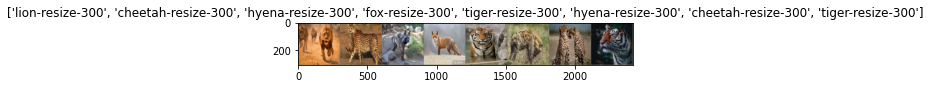

In [6]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Functions

In [7]:
def test_model(model):
    model.eval()

    running_corrects = 0

    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
     
            running_corrects += torch.sum(preds == targets.data)

    
    acc = running_corrects.double()/test_len
    return round(acc.item(), 5)

def train_model(model, criterion, optimizer, schedular, num_epoch=3):

    since = time.time()
    list_of_loss = []
    model.train()
    for epoch in tqdm(range(num_epoch)):

        print(f'Current epoch is {epoch + 1}/{num_epoch}')
        curr_loss = 0
        epoch_loss = 0

        for inputs, labels in train_dataloader:
    
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            curr_loss += loss.item() * inputs.size(0)
    
            
        if schedular != None:
            schedular.step()
        epoch_loss = curr_loss/train_len
        print(f'Loss is {epoch_loss}')
        list_of_loss.append(epoch_loss)
  

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return list_of_loss

def set_seed(n):
    random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    
def set_model(n):
    set_seed(n)
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    num_in_feat = model.fc.in_features
    model.fc = nn.Linear(num_in_feat, 6)
    model = model.to(device)
    
    return model
    

# Models.
I use same pretrained Resnet18 model. Each time I change optimizer and schedular. 

# 1 Approach:
Do not change learning rate

In [8]:
model_1 = set_model(42)
optimizer_1 = optim.Adam(model_1.parameters(), lr = 0.01)
criterion_1 = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
test_model(model_1)


0.12791

In [10]:
train_model(model_1, criterion_1, optimizer_1, schedular = None)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Loss is 0.5533953632917581
Current epoch is 2/3
Loss is 0.23256238178923713
Current epoch is 3/3
Loss is 0.24635764010355649
Training complete in 6m 25s


[0.5533953632917581, 0.23256238178923713, 0.24635764010355649]

In [11]:
test_model(model_1)

0.95058

# 2 Approach:
Train a model with [Step_lr](http://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR) shcedular, so every N steps learning rate is multiplied by gamma. [MultiStepLR ](http://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR)also might be used where learning rate changes once the number of epoch reaches one of the milestones. 

In [12]:
model_2 = set_model(42)
optimizer_2 = optim.Adam(model_2.parameters(), lr = 0.01)
criterion_2 = nn.CrossEntropyLoss()
lr_schedular_2 = lr_scheduler.StepLR(optimizer_2, step_size=2, gamma=0.1) # every 2 steps decrease lr by 10 times

In [13]:
test_model(model_2)

0.12791

In [14]:
train_model(model_2, criterion_2, optimizer_2, lr_schedular_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.5533953632917581
Current epoch is 2/3
Loss is 0.23256238178923713
Current epoch is 3/3
Loss is 0.09416809605758494
Training complete in 6m 14s


[0.5533953632917581, 0.23256238178923713, 0.09416809605758494]

In [15]:
test_model(model_2)

0.98547

# 3 Approach
Set different learning rates for diferent layers. Or Layer-Wise Learning Rate. The key idea is to gradually reduce the learning rate when going deeper into the network.

In [16]:
model_3 = set_model(42)

list_of_layers = []
for layer in model_3.named_parameters():
    list_of_layers.append(layer[0])
list_of_layers.reverse()
lr = 0.01  
parameters = []
prev_group_name = list_of_layers[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(list_of_layers):
    
    cur_group_name = name.split('.')[0]
    
    # update learning rate
    if cur_group_name != prev_group_name:
        lr *= 0.8
    prev_group_name = cur_group_name
    
    
    #print(f'lr = {lr:.4f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model_3.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

optimizer_3 = optim.Adam(parameters)
creterion_3 = nn.CrossEntropyLoss()



In [17]:
train_model(model_3, creterion_3, optimizer_3, schedular = None)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.7331502625233042
Current epoch is 2/3
Loss is 0.40538718910263133
Current epoch is 3/3
Loss is 0.3124226102620745
Training complete in 6m 21s


[0.7331502625233042, 0.40538718910263133, 0.3124226102620745]

In [18]:
test_model(model_3)

0.99128

# 4 Approach
Use any function to change learning rate. [Lambda Shcedular](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR)

In [19]:
model_4 = set_model(42)
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=0.01)
lambda_4 = lambda epoch: 0.9 ** epoch
schedular_4 = lr_scheduler.LambdaLR(optimizer_4, lambda_4)
criterion_4 = nn.CrossEntropyLoss()

In [20]:
for epoch in range(5):

    optimizer_4.step()
    schedular_4.step()

    print(optimizer_4.state_dict()['param_groups'][0]['lr'])

0.009000000000000001
0.008100000000000001
0.007290000000000001
0.006561
0.005904900000000001


In [21]:
train_model(model_4, criterion_2, optimizer_4, schedular_4)

  0%|          | 0/3 [00:00<?, ?it/s]

Current epoch is 1/3
Loss is 0.550077268906692
Current epoch is 2/3
Loss is 0.2058556651897004
Current epoch is 3/3
Loss is 0.16748430373202072
Training complete in 6m 19s


[0.550077268906692, 0.2058556651897004, 0.16748430373202072]

In [22]:
test_model(model_4)

0.98837

# 5 Approach
[ReduceLRonPlateau ](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau). Reduce learning rate when a metric has stopped improving. This time schedular step should be called after validation step. 

In [23]:
def train_model_with_test(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'test':
                scheduler.step(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

In [24]:
model_5 = set_model(42)
creterion_5 = nn.CrossEntropyLoss()
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr=0.01)
schedular_5 = lr_scheduler.ReduceLROnPlateau(optimizer_5, mode='min', factor=0.1, patience=3) 
#patience is how long wait with no improvement (by defoult 10)

In [25]:
train_model_with_test(model_5, creterion_5, optimizer_5, schedular_5)

Epoch 1/3
----------
train Loss: 0.9547 Acc: 0.7604
test Loss: 0.1257 Acc: 0.9826

Epoch 2/3
----------
train Loss: 0.8839 Acc: 0.8208
test Loss: 0.0632 Acc: 0.9913

Epoch 3/3
----------
train Loss: 0.8737 Acc: 0.8318
test Loss: 0.1090 Acc: 0.9855

Training complete in 7m 42s


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  